Say we want to evalute the impact of taking a class online on student performance. We can't simply offer two versions of a class, one online and one in-person, and then compare the performance of the two groups of students. This is because the students who choose to take the online class may be different from those who choose to take the in-person class. For example, students who take the online class may be more motivated and self-directed. To account for this, we can randomize students into the two groups. This is called a randomized controlled trial, or RCT for short.
```

Alpert et al, 2016 conduct exactly this analysis. Let's first clean their raw data:

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('retina')

In [161]:
df = pd.read_stata("data/online_learning_rct.dta")
df = (
    df[(df["enroll_count"] == 3) & (df["format_blended"] == 0)]
    .assign(format_ol=lambda x: x["format_ol"].astype(bool))
    .rename(
        columns={
            "falsexam": "Final Exam Score",
            "format_ol": "Online Format",
        }
    )[["Online Format", "Final Exam Score"]]
)

In [162]:
df.head()

,Online Format,Final Exam Score
151,False,63.299969
152,False,79.959999
155,True,83.300003
157,True,88.349960
159,False,90.000000


We can plot the distribution of grades for each group:

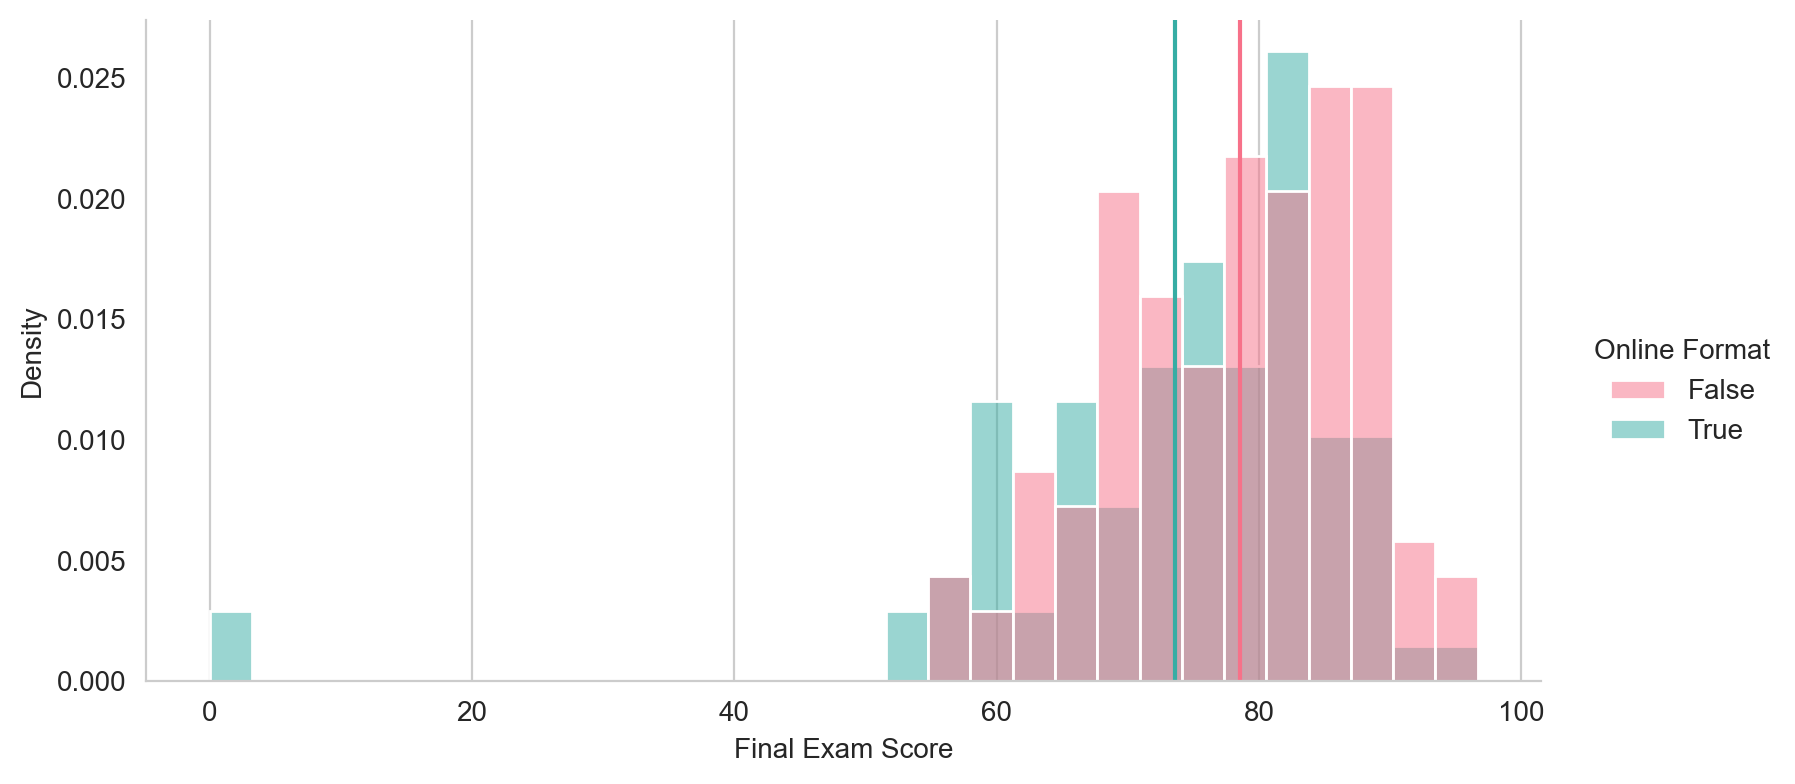

In [165]:
sns.displot(
    data=df,
    x="Final Exam Score",
    hue="Online Format",
    stat="density",
    bins=30,
    palette="husl",
    height=4,
    aspect=2,
)
plt.axvline(
    x=df[df["Online Format"]]["Final Exam Score"].mean(),
    color=sns.color_palette("husl")[3],
)
plt.axvline(
    x=df[~df["Online Format"]]["Final Exam Score"].mean(),
    color=sns.color_palette("husl")[0],
)
plt.grid(axis="x")
plt.show()

Let's compute the numerical values for the means of each group:

In [167]:
(
    df.groupby("Online Format")
    .mean()
    .reset_index()
    .rename(columns={"Final Exam Score": "Mean Final Exam Score"})
)

,Online Format,Mean Final Exam Score
0,False,78.547485
1,True,73.635262


We can see that students in the online class are faring worse by 78.54 - 73.63 = 4.91 points. But how can we be sure this isn't a statistical fluke?  To answer this, we'll consider the following question: What is the probability that, given in-person and online classes have the same average grade, we would observe a difference in average grade as large as the one we observed in our data? Let's formulate this mathematically.

Let $X$ denote the difference in means between the two groups. We can write this as $X = \bar{X}_1 - \bar{X}_2$ where $\bar{X}_1$ and $\bar{X}_2$ are the sample means of the in-person and online classes respectively. We can then write the probability we're interested in as:
$P(|X| > 4.91).$
We call this the p-value. It is the probability that, given the null hypothesis that the two groups have the same average grade (i.e. $\bar{X}=0$), we would observe a difference in average grade as large as the one we observed in our data. If this probability is small, then we can reject the null hypothesis and conclude that the two groups do not have the same average grade. Usually, the threshold for rejecting the null hypothesis is 0.05 by convention.

Notice that that $P(|X| > 4.91) = P(X> 4.91) + P(X< -4.91) = 2P(X< -4.91) = 2\Phi(\frac{-4.91}{\sigma})$

So we want to check whether $2\Phi(\frac{-4.91}{\sigma}) < 0.05$. But first, we need to calculate $\sigma$.

Recall $X = \bar{X}_1 - \bar{X}_2$, which implies that $Var(X) = Var(\bar{X}_1) + Var(\bar{X}_2)$.

Of course, the mean of a random variable $X$ is just $\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i$.
We can therefore derive its variance as follows:

$\begin{aligned} \operatorname{Var}\left[\bar{X}\right] & =\operatorname{Var}\left[\frac{1}{n} \sum_{i=1}^n X_i\right] \\ & =\frac{1}{n^2} \operatorname{Var}\left[\sum_{i=1}^n X_i\right] \\ & =\frac{1}{n^2} \sum_{i=1}^n \operatorname{Var}\left[X_i\right] \\ & =\frac{1}{n^2} \sum_{i=1}^n \sigma^2 \\ & =\frac{1}{n^2} n \sigma^2=\frac{\sigma^2}{n}\end{aligned}$

Thus, the variance of $X = \bar{X}_1 - \bar{X}_2$ is $\begin{aligned}\frac{\sigma_1^2}{n_1}+\frac{\sigma_2^2}{n_2}\end{aligned}$

Now, let's calculate the p-value:

In [178]:
online = df[df["Online Format"]]["Final Exam Score"]
in_person = df[~df["Online Format"]]["Final Exam Score"]
sigma1, mu1, n1 = online.std(), online.mean(), online.shape[0]
sigma2, mu2, n2 = in_person.std(), in_person.mean(), in_person.shape[0]

# Calculate the standard deviation of X
sd = np.sqrt(((sigma1**2) / n1) + ((sigma2**2) / n2))
p_val = 2 * norm.cdf(-abs(mu1 - mu2) / sd)
print(f"p-value: {p_val:.4f}")

p-value: 0.0054


We have shown that, if there were no difference between the two groups, the probability of observing a difference at least as large as the one we observed is 0.0054. We can therefore reject the null hypothesis and conclude that the two groups do not have the same average grade.